# 2017-09-08 Quicklook to investigate BaSTi truncation #

**Purpose:** examine if BaSTi is truncating objects that lie outside its canonical isochrone metallicity range, and, if so, try to determine what the effects are and where along the process this truncation happens. 

In [21]:
# import a few needed things
import os
import numpy as np
from astropy.table import Table

In [22]:
import matplotlib.pylab as plt
%matplotlib inline

In [23]:
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

In [24]:
! pwd

/Users/clarkson/Progs/Projects/bastiTest/notebooks


In [25]:
# set up path for all our figures
dirPlots = './plots'
if not os.access(dirPlots, os.R_OK):
    os.mkdir(dirPlots)

In [26]:
# directory for synthetic populations and .sfh files
dirSupport = '../supporting/synthPops'

## Define a few useful methods ##

In [27]:
def readSFH(pathIn='BLAH'):
    
    """Reads the star formation history file"""
    
    if not os.access(pathIn, os.R_OK):
        return Table()
    
    tDum = Table.read(pathIn, format='ascii.commented_header', data_start=1, comment='#')
    
    # assign the columns
    colNames = ['Age', 'Rate', 'meanFeH', 'sigmFeH']
    for iName in range(len(colNames)):
        tDum[tDum.colnames[iName]].name = colNames[iName]
        
    return tDum

In [28]:
def performSubselection(tPho=Table(), xLo=0.7, xHi=0.8, yLo=5.0, yHi=8.0, \
                       colMagBlu='F606Wacs', colMagRed='F814Wacs', colMagMag='F606Wacs'):
    
    """Return boolean selection indices for non-binaries and for polygon"""
    
    vMag = tPho[colMagMag]
    vCol = tPho[colMagBlu] - tPho[colMagRed]
    
    # not a binary?
    bBinaries = tPho['M2'] > 0
    
    # inside polygon?
    bPoly = (vCol >= xLo) & (vCol < xHi) & (vMag >= yLo) & (vMag < yHi)
    
    return vCol, vMag, bBinaries, bPoly
    

In [29]:
def findMedianSequence(vCol, vMag, bShow, bPoly, xLo=0.7, xHi=0.8, yLo=5.0, yHi=8.0, degFit=2, \
                       nMed=10, nMin=10, useMin=False):
    
    """Gets the median sequence for the population."""

    # We'll assume the booleans have been defined elsewhere
    
    # find the median sequence in our selection box. For this quicklook, we don't have to be too sophisticated here...
    vXlo = np.linspace(xLo, xHi, nMed, endpoint=False)
    vXhi = vXlo + (vXlo[1]-vXlo[0])

    # medians
    vXmed = vXlo * 0.
    vYmed = vXmed * 0.
    bGood = np.isfinite(vXmed)
    
    for iMed in range(np.size(vXlo)):
        bHere = (bShow) & (bPoly) & (vCol >= vXlo[iMed]) & (vCol < vXhi[iMed])
        
        if np.sum(bHere) < nMin:
            bGood[iMed] = False
            continue
        
        if not useMin:
            vXmed[iMed] = np.median(vCol[bHere])
            vYmed[iMed] = np.median(vMag[bHere])
        else:
            iMax = np.argmin(vMag[bHere])
            vXmed[iMed] = np.copy(vCol[bHere][iMax])
            vYmed[iMed] = np.copy(vMag[bHere][iMax])
            
    
    # trim by passed...
    vXmed = vXmed[bGood]
    vYmed = vYmed[bGood]
    
    # ... and fit the median sequence to this
    parsMed = np.polyfit(vXmed, vYmed, deg=degFit)
    
    return parsMed, vXmed, vYmed
    

In [30]:
# refactored our plotting into a method
def showSelectedData(tPop, bShow, xLo, xHi, yLo, yHi, \
                         vXmed, vYmed, parsMed, \
                    colorMin=0.4, colorMax=1.0, magMin=3., magMax=8., \
                    cmFeH='jet', \
                    colMagBlu='F606Wacs', colMagRed='F814Wacs', colMagMag='F606Wacs', \
                    figNam='TEST', sTitle=''):
    
    """Plot the metallicities commanded and the CMD resulting"""

    # plot the commanded metallicities
    fig1 = plt.figure(1, figsize=(12,5))
    fig1.clf()

    # what color-scheme shall we use?
    #cmFeH = 'jet'

    # CMD plot limits
    #colorMin = 0.3
    #colorMax = 1.5
    #magMin = 0.
    #magMax = 8.

    # duplicative for the moment...
    vMag = tPop[colMagMag]
    vCol = tPop[colMagBlu] - tPop[colMagRed]
    
    # Do the plots
    ax1 = fig1.add_subplot(1,2,1)
    dumFeH = ax1.scatter(tPop['ID'][bShow], tPop['FeH'][bShow], s=4, alpha=0.25, edgecolor='0.7', c='0.2')
    ax1.set_xlabel('ID')
    ax1.set_ylabel('[Fe/H]')

    ax2 = fig1.add_subplot(1,2,2)
    dumCMD = ax2.scatter(vCol[bShow], vMag[bShow], c=tPop['FeH'][bShow], \
                         s=9, alpha=1.0, edgecolor='None', cmap=cmFeH, \
                        zorder=2, label='')
    ax2.set_xlabel(r'$(%s - %s)_0$' % (colMagBlu, colMagRed))
    ax2.set_ylabel(r'$%s_0$' % (colMagMag))

    # hardwire some limits
    ax2.set_xlim(colorMin,colorMax)
    ax2.set_ylim(magMax, magMin)  # [sic]

    # show the selection polygon
    xPoly = np.array([xLo, xHi, xHi, xLo, xLo])
    yPoly = np.array([yLo, yLo, yHi, yHi, yLo])
    plt.plot(xPoly, yPoly, 'k--', zorder=15, label='')

    # overplot the median sequence
    xDum = np.linspace(xLo, xHi, 500)
    plt.plot(vXmed, vYmed, 'ko', zorder=5, ms=6, ls='-', label='Adopted fiducial')
    plt.plot(xDum, np.polyval(parsMed, xDum), 'k-', zorder=5)


    ax2.set_title(r'CMD color-coded by $[Fe/H]$')
    ax1.set_title(r'$[Fe/H]$, all simulated objects')
    
    cbar = fig1.colorbar(dumCMD, label=r'$[Fe/H]$')
    
    leg = ax2.legend(loc=3)
    
    fig1.subplots_adjust(hspace=0.40, wspace=0.45, top=0.85)
    

    
    # add a supertitle if given
    if len(sTitle) > 0:
        fig1.suptitle(sTitle, fontsize=14, y=0.95)
    
    if len(figNam) > 2:
        fig1.savefig(figNam)


In [31]:
# refactored our plotting cell into a method...
def showDeltas(difSel, fehSel, colSel, idSel, nBins=50, \
               cmapVsFeh='RdBu_r', cmapVsCol='jet', \
              colMagBlu='F606Wacs', colMagRed='F814Wacs', \
              colMagMag='F606Wacs', figNam='TEST', \
              sTitle=''):

    
    """Show the deltas cut various ways"""
    
    # OK now show the residuals from the median as a function of color and metallicity...
    fig2 = plt.figure(2, figsize=(12,8))
    fig2.clf()

    ax21 = fig2.add_subplot(2,2,2)
    ax22 = fig2.add_subplot(2,2,1, sharex=ax21)
    ax23 = fig2.add_subplot(2,2,3, sharex=ax22)
    ax24 = fig2.add_subplot(2,2,4)

    # for convenience labeling
    sLabelDelta = r'$\Delta %s_0$' % (colMagMag)
    sLabelColor = r'$(%s - %s)_0$' % (colMagBlu, colMagRed)
    sLabelFeh = r'$[Fe/H]_0$'

    # scatter - delta vs commanded [Fe/H]
    dumResFeH = ax21.scatter(difSel, fehSel, c=colSel, cmap=cmapVsFeh, \
                             alpha=1.0, edgecolor='None', s=9)
    ax21.set_ylabel(sLabelFeh)
    ax21.set_xlabel(sLabelDelta)


    axins21 = inset_axes(ax21,
               width="5%", # width = 10% of parent_bbox width
               height="100%", # height : 50%
               loc=6,
               bbox_to_anchor=(1.00, 0., 1, 1),
               bbox_transform=ax21.transAxes,
               borderpad=0)
    cbar21 = fig2.colorbar(dumResFeH, cax=axins21, label=sLabelColor)
    #cbar21.set_label(sLabelColor, rotation=270)
    
    ax21.set_title(r'%s vs %s' % (sLabelFeh, sLabelDelta))

    # scatter - delta vs color
    dumResCol = ax22.scatter(difSel, colSel, c=fehSel, cmap=cmapVsCol, \
                            alpha=1.0, edgecolor='None', s=16)
    ax22.set_ylabel(sLabelColor)
    ax22.set_xlabel(sLabelDelta)

    axins22 = inset_axes(ax22,
               width="5%", # width = 10% of parent_bbox width
               height="100%", # height : 50%
               loc=6,
               bbox_to_anchor=(1.00, 0., 1, 1),
               bbox_transform=ax22.transAxes,
               borderpad=0)
    cbar22 = fig2.colorbar(dumResCol, cax=axins22, label=sLabelFeh)
    #cbar22.set_label(sLabelFeh, rotation=0)
    
    ax22.set_title(r'%s vs %s' % (sLabelColor, sLabelDelta))
    

    
    # histogram of deltas
    dumHist = ax23.hist(difSel, bins=nBins, \
                        #range=[-0.2,0.5], \
                        range=[np.min(difSel)-0.1, np.max(difSel)+0.1], \
                        orientation='vertical', \
                       color='0.7', alpha=0.7, zorder=5)
    ax23.set_xlabel(sLabelDelta)
    ax23.set_ylabel(r'N(%s)' % (sLabelDelta))

    ax23.set_title(r'%s histogram' % (sLabelDelta))
    
    # like our first plot, this time only the polygon-selected objects
    dumIDs = ax24.scatter(idSel, fehSel, c=difSel, cmap='viridis', \
                         alpha=0.7, edgecolor='None', s=9)
    ax24.set_xlabel('ID')
    ax24.set_ylabel(sLabelFeh)

    axins24 = inset_axes(ax24,
               width="5%", # width = 10% of parent_bbox width
               height="100%", # height : 50%
               loc=6,
               bbox_to_anchor=(1.00, 0., 1, 1),
               bbox_transform=ax24.transAxes,
               borderpad=0)

    cbar24 = fig2.colorbar(dumIDs, cax=axins24, label=sLabelDelta)
    #cbar24.set_label(sLabelDelta, rotation=270)
    
    ax24.set_title(r'%s vs ID' % (sLabelFeh))
    
    fig2.subplots_adjust(hspace=0.40, wspace=0.45, top=0.85)
    
    # add a supertitle if given
    if len(sTitle) > 0:
        fig2.suptitle(sTitle, fontsize=14, y=0.95)
    
    if len(figNam) > 2:
        fig2.savefig(figNam)

In [32]:
# wrapper for our analysis
def wrapCheckBasti(stemPop = 'metRich_fewBinaries_ss_eta0p4_', \
                   degFit=3, nMed=15, nMin=10, \
                   xLo=0.7, xHi=0.9, yLo=5.0, yHi=7.5, \
                    colMagBlu='F606Wacs', colMagRed='F814Wacs', \
                   figStem='TEST', sTitle='', \
                  stripes=False, bothFigs=True):
    
    """Wrapper for the delta-mag check"""
    
    pathSFH = '%s/%s.sfh' % (dirSupport, stemPop)
    pathPOP = '%s/%s_hrd.fits.gz' % (dirSupport, stemPop)
    
    for thisPath in [pathSFH, pathPOP]:
        if not os.access(thisPath, os.R_OK):
            print "wrapCheckBasti WARN - cannot read input path %s" % (thisPath)
            return
        
    # load the population and its sfh
    tPop = Table.read(pathPOP, format='fits')
    tSfh = readSFH(pathSFH)
    
    tSfh.pprint()
    
    colMagBlu = 'F606Wacs'
    colMagRed = 'F814Wacs'
    colMagMag = colMagBlu[:]

    # make the convenience-variables
    vCol, vMag, bBinaries, bPoly = performSubselection(tPop, xLo, xHi, yLo, yHi, \
                                                       colMagBlu, colMagRed, colMagMag)
    
    # anticipating other selections, let's set up a boolean now for only the objects we want to show...
    bShow = np.copy(~bBinaries)

    # now find the median sequence
    parsMed, vXmed, vYmed = findMedianSequence(vCol, vMag, bShow, bPoly, \
                                               xLo, xHi, yLo, yHi, \
                                               degFit, nMed, nMin, \
                                              useMin=stripes)
    
    print np.sum(bShow)
    # What we'll actually use for the deltas later on...
    bSel = (bShow) & (bPoly)
    colSel = vCol[bSel]
    magSel = vMag[bSel]
    difSel = vMag[bSel] - np.polyval(parsMed, colSel)
    fehSel = tPop['FeH'][bSel]
    idSel = tPop['ID'][bSel]
            
    # and make the figures. Include figure names
    figNamSelect = '%s_select.png' % (figStem)
    figNamDeltas = '%s_deltas.png' % (figStem)
    showSelectedData(tPop, bShow, xLo, xHi, yLo, yHi, vXmed, vYmed, parsMed, \
                    colMagBlu=colMagBlu, colMagRed=colMagRed, colMagMag=colMagMag, \
                    figNam=figNamSelect, sTitle=sTitle)
    
    if bothFigs:
        showDeltas(difSel, fehSel, colSel, idSel, figNam=figNamDeltas, sTitle=sTitle)

## Common parameters ##

In [42]:
# set up a selection region in the CMD to estimate a "main sequence"
xLo = 0.65
xHi = 0.75
yLo = 5.0
yHi = 7.5

# control variables for the fit
degFit=2
nMed=15
nMin=10

In [43]:
# columns for the CMD - make the colors for convenience here
#colMagBlu = 'F606Wacs'
#colMagRed = 'F814Wacs'
#colMagMag = colMagBlu[:]

#vMag = tPop[colMagMag]
#vCol = tPop[colMagBlu] - tPop[colMagRed]

## Now try the various test-cases ##

### Metal-rich, scaled-to-solar: [Fe/H] = +0.24 +/- 0.19 ### 

In [44]:
stemPop = 'metRich_fewBinaries_ss_eta0p4_'
sStem='%s/testMetRich' % (dirPlots)
sTitl='metal-rich, scaled-to-solar, eta=0.4'

    Age      Rate meanFeH sigmFeH
------------ ---- ------- -------
8000000000.0  1.0    0.24    0.19
8000000000.0  0.0    0.24    0.19
20222


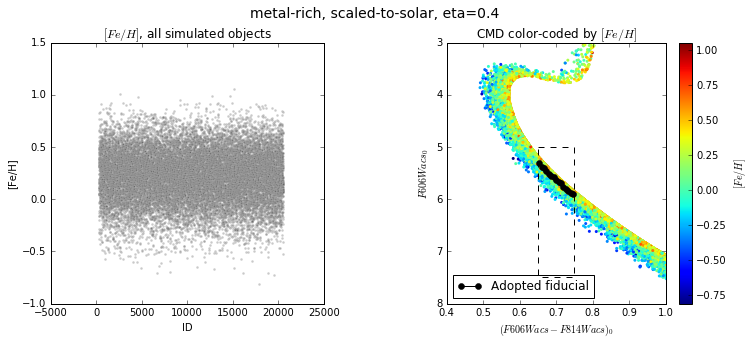

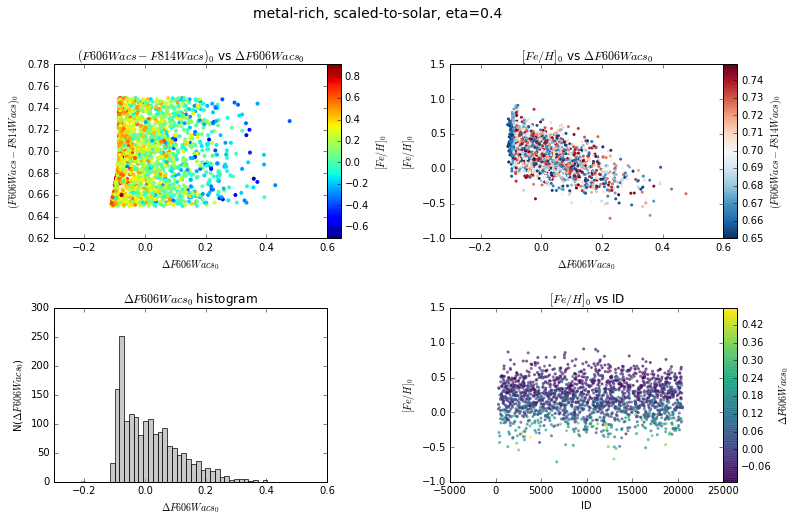

In [45]:
# let's try our wrapper
wrapCheckBasti(stemPop, degFit, nMed, nMin, xLo, xHi, yLo, yHi, figStem=sStem, sTitle=sTitl, bothFigs=True)

### "Test-pattern:" Scaled-to-solar, [Fe/H] = -3.0, -2.5, -2.0, -1.5, -1.0, -0.5, 0.0, +0,4, +0.5, all +/- 0.0001 dex###

In [46]:
stemPop2 = 'testPattern_ss_metalRich_smallDispersion'
sStem2='%s/testPatternSmallDispersion' % (dirPlots)
sTitl2='[Fe/H] = -3.0, -2.5... +0.4, +0.5, all +/- 0.0001 dex'

    Age      Rate meanFeH sigmFeH
------------ ---- ------- -------
7000000000.0  0.1    -3.0     0.0
7000000000.0  0.0    -3.0     0.0
7000000000.0  0.1    -2.5     0.0
7000000000.0  0.0    -2.5     0.0
7000000000.0  0.1    -2.0     0.0
7000000000.0  0.0    -2.0     0.0
7000000000.0  0.1    -1.5     0.0
7000000000.0  0.0    -1.5     0.0
7000000000.0  0.1    -1.0     0.0
7000000000.0  0.0    -1.0     0.0
7000000000.0  0.1    -0.5     0.0
7000000000.0  0.0    -0.5     0.0
7000000000.0  0.1     0.0     0.0
7000000000.0  0.0     0.0     0.0
7000000000.0  0.1     0.4     0.0
7000000000.0  0.0     0.4     0.0
7000000000.0  0.1     0.5     0.0
7000000000.0  0.0     0.5     0.0
59310


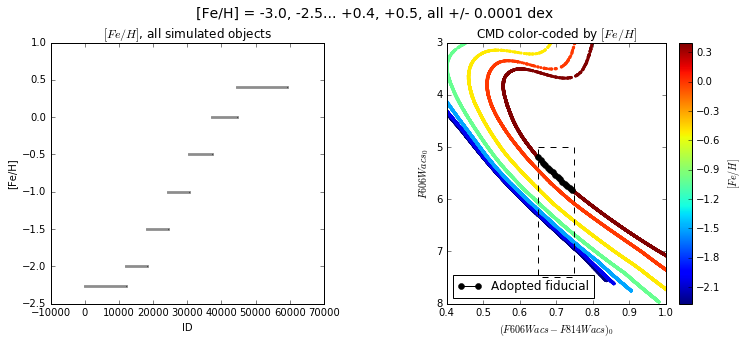

In [47]:
wrapCheckBasti(stemPop2, degFit, nMed, nMin, xLo, xHi, yLo, yHi, figStem=sStem2, sTitle=sTitl2, stripes=True, \
              bothFigs=False)

### "Test-pattern:" Scaled-to-solar, [Fe/H] = -3.0, -2.5, -2.0, -1.5, -1.0, -0.5, 0.0, +0,4, +0.5, all +/- 0.1 dex###

In [48]:
stemPop3 = 'testPattern_ss_metalRich_medDispersion'
sStem3='%s/testPatternMedDispersion' % (dirPlots)
sTitl3='[Fe/H] = -3.0, -2.5... +0.4, +0.5, all +/- 0.1 dex'

    Age      Rate meanFeH sigmFeH
------------ ---- ------- -------
7000000000.0  0.1    -3.0     0.1
7000000000.0  0.0    -3.0     0.1
7000000000.0  0.1    -2.5     0.1
7000000000.0  0.0    -2.5     0.1
7000000000.0  0.1    -2.0     0.1
7000000000.0  0.0    -2.0     0.1
7000000000.0  0.1    -1.5     0.1
7000000000.0  0.0    -1.5     0.1
7000000000.0  0.1    -1.0     0.1
7000000000.0  0.0    -1.0     0.1
7000000000.0  0.1    -0.5     0.1
7000000000.0  0.0    -0.5     0.1
7000000000.0  0.1     0.0     0.1
7000000000.0  0.0     0.0     0.1
7000000000.0  0.1     0.4     0.1
7000000000.0  0.0     0.4     0.1
7000000000.0  0.1     0.5     0.1
7000000000.0  0.0     0.5     0.1
59314


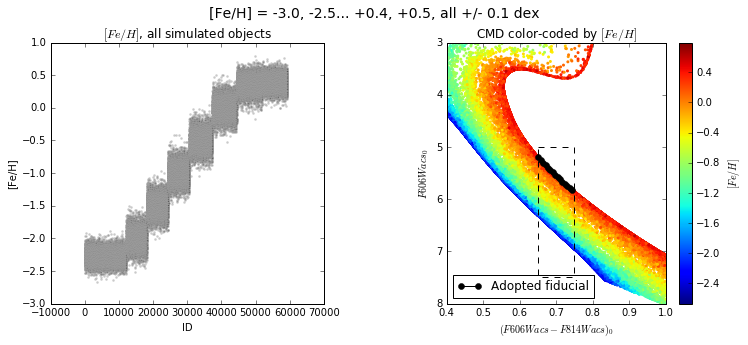

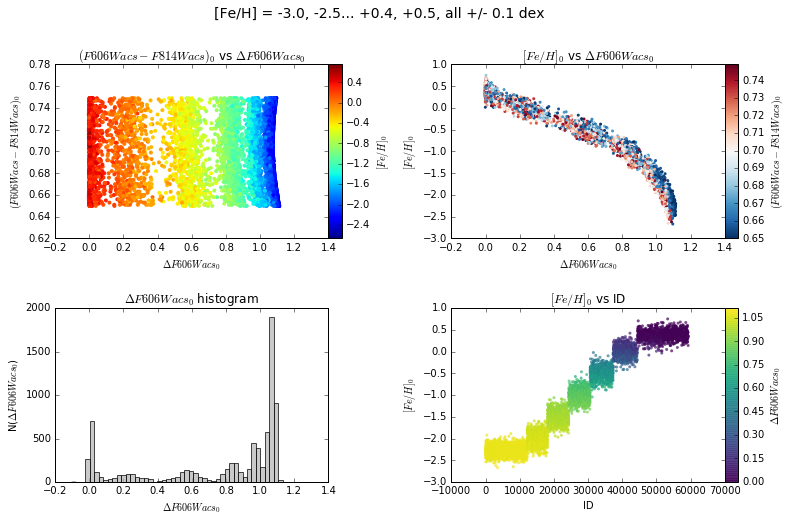

In [49]:
wrapCheckBasti(stemPop3, degFit, nMed, nMin, xLo, xHi, yLo, yHi, figStem=sStem3, sTitle=sTitl3, stripes=True, \
              bothFigs=True)

## Old step-by-step ##